Bottleneck distances (drop essentials): {0: 6.512625834651815e-309, 1: 0.001985266403287462}
Wasserstein distances (q=1): {0: np.float64(0.0), 1: np.float64(0.03274790958377286)}


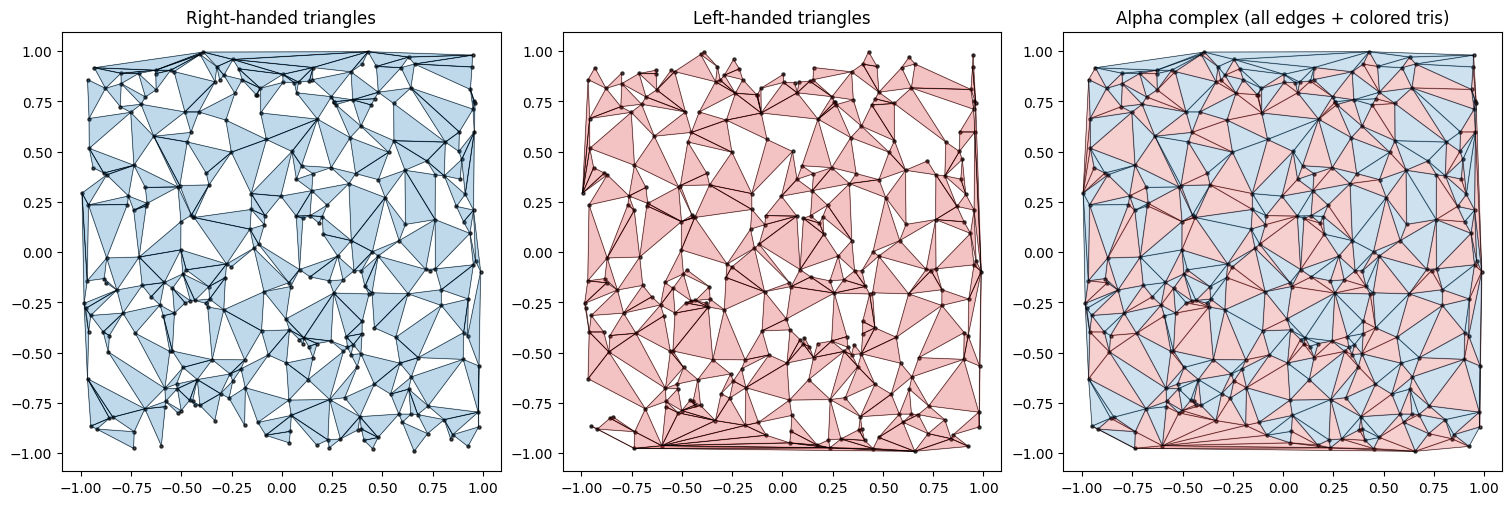

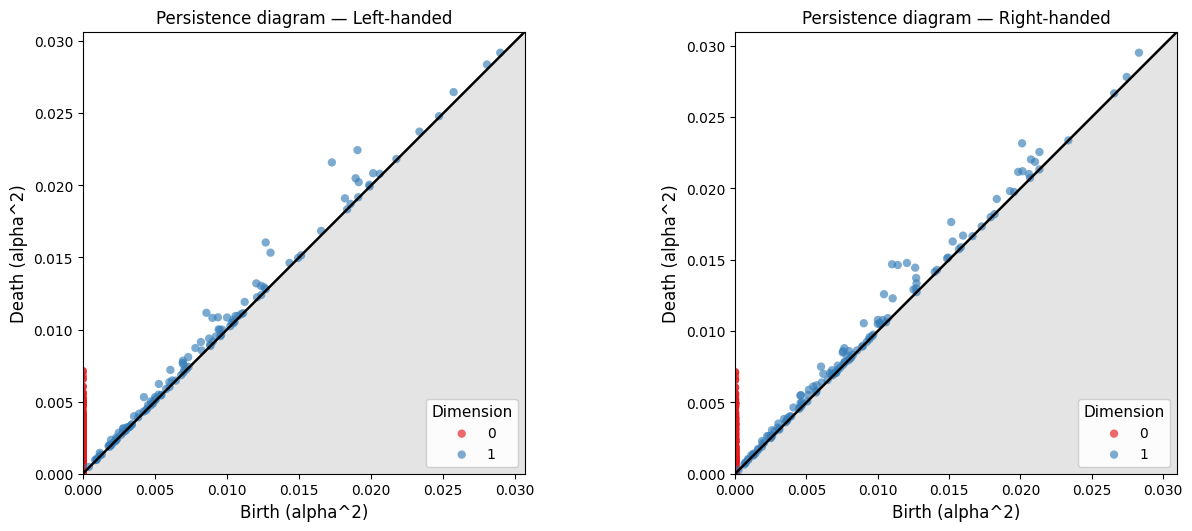

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from matplotlib.patches import Polygon
from typing import Dict, Iterable, Tuple, List, Optional

# =============================================================
# Chiral Persistent Homology in 2D (complete rewrite)
# -------------------------------------------------------------
# - Builds an Alpha complex (filtration in alpha^2 per GUDHI)
# - Splits triangles by handedness using a *canonical* signed area
# - Creates LEFT-only and RIGHT-only subcomplexes (all vertices/edges kept)
# - Computes persistence diagrams, bottleneck & wasserstein distances
# - Plots pretty PDs (diagonal + shaded triangle) and colored complexes
# - Works in notebooks (show=True) and/or saves to files (path=...)
# =============================================================

class ChiralPersistentHomology2D:
    def __init__(
        self,
        points: np.ndarray,
        max_alpha: Optional[float] = None,   # threshold in *alpha* units; None means no cut
        drop_infinite: bool = True,
    ):
        """
        Parameters
        ----------
        points : array-like, shape (N, >=2)
            2D coordinates (only x,y used). Extra columns are ignored.
        max_alpha : float or None
            If provided, drop all triangles with filtration > max_alpha.
            Internally converts to alpha^2 (GUDHI filtration units).
        drop_infinite : bool
            If True, exclude intervals with death = inf from PDs by default.
        """
        P = np.asarray(points)
        assert P.ndim == 2 and P.shape[1] >= 2, "points must be (N,>=2)"
        self.XY = P[:, :2].astype(float, copy=True)
        self.max_alpha2 = None if max_alpha is None else float(max_alpha) ** 2
        self.drop_inf_default = bool(drop_infinite)

    # ---------------------------
    # Alpha complex + extraction
    # ---------------------------
    def _alpha_simplex_tree(self) -> gd.SimplexTree:
        ac = gd.AlphaComplex(points=self.XY)
        return ac.create_simplex_tree()

    @staticmethod
    def _canonical_signed_area(xy3: np.ndarray) -> float:
        """Deterministic oriented area for a triangle (3x2 array).
        Sort vertices lexicographically (x,y) to make the sign independent
        of vertex ordering returned by GUDHI.
        """
        tri = np.asarray(xy3)
        order = np.lexsort((tri[:, 1], tri[:, 0]))
        p0, p1, p2 = tri[order]
        v1, v2 = p1 - p0, p2 - p0
        return v1[0] * v2[1] - v1[1] * v2[0]

    def _extract_vertices_edges_tris(self, st: gd.SimplexTree):
        """Collect filtration values for 0-,1-,2-simplices.
        Returns:
            verts_alpha2: dict[i] -> a2
            edges_alpha2: dict[(i,j)] -> a2  (i<j)
            tris_alpha2 : list of (i,j,k,a2)  (no ordering guaranteed)
        """
        #consider doing matrix form

        
        verts_alpha2: Dict[int, float] = {}
        edges_alpha2: Dict[Tuple[int,int], float] = {}
        tris_alpha2: List[Tuple[int,int,int,float]] = []

        for simplex, a2 in st.get_skeleton(2):
            dim = len(simplex) - 1
            if dim == 0:
                i = int(simplex[0]); verts_alpha2[i] = float(a2)
            elif dim == 1:
                i, j = sorted(map(int, simplex))
                edges_alpha2[(i, j)] = float(a2)
            elif dim == 2:
                i, j, k = map(int, simplex)
                a2 = float(a2)
                if (self.max_alpha2 is None) or (a2 <= self.max_alpha2):
                    tris_alpha2.append((i, j, k, a2))
        return verts_alpha2, edges_alpha2, tris_alpha2

    # ---------------------------
    # Build chiral subcomplexes
    # ---------------------------
    def _split_triangles(self, tris_alpha2):
        RH, LH = [], []
        for i, j, k, a2 in tris_alpha2:
            sa = self._canonical_signed_area(self.XY[[i, j, k]])
            if sa > 0:
                RH.append(((i, j, k), a2))
            elif sa < 0:
                LH.append(((i, j, k), a2))
            # sa == 0 → degenerate; ignore
        return RH, LH

    @staticmethod
    def _build_subcomplex(verts_alpha2, edges_alpha2, tris_keep) -> gd.SimplexTree:
        st = gd.SimplexTree()
        for i, a2 in verts_alpha2.items():
            st.insert([i], filtration=a2)
        for (i, j), a2 in edges_alpha2.items():
            st.insert([i, j], filtration=a2)
        for (i, j, k), a2 in tris_keep:
            st.insert([i, j, k], filtration=a2)
        return st

    def _left_right_subcomplexes(self):
        st_full = self._alpha_simplex_tree()
        verts_a2, edges_a2, tris_a2 = self._extract_vertices_edges_tris(st_full)
        RH, LH = self._split_triangles(tris_a2)
        LH_st = self._build_subcomplex(verts_a2, edges_a2, LH)
        RH_st = self._build_subcomplex(verts_a2, edges_a2, RH)
        return LH_st, RH_st

    # ---------------------------
    # Persistence + distances
    # ---------------------------
    @staticmethod
    def _pd_from_st(st: gd.SimplexTree, drop_inf=True):
        pd = st.persistence()
        return [(d, (b, de)) for d, (b, de) in pd if (not drop_inf) or np.isfinite(de)]

    def chiral_persistence(self, drop_inf: Optional[bool] = None):
        if drop_inf is None:
            drop_inf = self.drop_inf_default
        LH_st, RH_st = self._left_right_subcomplexes()
        return self._pd_from_st(LH_st, drop_inf), self._pd_from_st(RH_st, drop_inf)

    @staticmethod
    def _pairs_for_dim(diag, dim: int):
        return [bd for d, bd in diag if d == dim]

    def bottleneck_distance(self, handle_essential: str = "drop", cap: Optional[float] = None):
        """Per-dimension bottleneck distances.
        handle_essential: 'drop' (recommended) or 'cap' (replace inf deaths).
        cap: if provided, used in 'cap' mode; else auto = 1.05*max finite death.
        """
        LH, RH = self.chiral_persistence(drop_inf=(handle_essential == "drop"))
        if handle_essential == "cap":
            # add back essentials, then cap
            LH, RH = self.chiral_persistence(drop_inf=False)
            def cap_inf(diag, capval):
                out = []
                for d, (b, de) in diag:
                    if np.isfinite(de):
                        out.append((d, (b, de)))
                    else:
                        out.append((d, (b, capval)))
                return out
            # auto cap if needed
            if cap is None:
                all_finite = []
                for diag in (LH, RH):
                    all_finite += [de for _, (_, de) in diag if np.isfinite(de)]
                cap = 1.05 * (max(all_finite) if all_finite else 1.0)
            LH = cap_inf(LH, cap); RH = cap_inf(RH, cap)

        out = {}
        for k in (0, 1):
            A = self._pairs_for_dim(LH, k)
            B = self._pairs_for_dim(RH, k)
            out[k] = gd.bottleneck_distance(A, B)
        return out

    def wasserstein_distance(self, q: float = 1.0):
        import gudhi.wasserstein as ws
        LH, RH = self.chiral_persistence(drop_inf=True)
        def to_arr(diag, k):
            arr = np.array(self._pairs_for_dim(diag, k), dtype=float)
            return arr if arr.size else np.empty((0, 2))
        return {k: ws.wasserstein_distance(to_arr(LH, k), to_arr(RH, k), order=q)
                for k in (0, 1)}

    # ---------------------------
    # Plotting
    # ---------------------------
    def plot_alpha_complex(self, path: Optional[str] = None, show: bool = True):
        LH_st, RH_st = self._left_right_subcomplexes()
        # Recompute triangles to color-fill
        _, edges_a2, tris_a2 = self._extract_vertices_edges_tris(self._alpha_simplex_tree())
        RH, LH = self._split_triangles(tris_a2)
        RH = [t for t, _ in RH]; LH = [t for t, _ in LH]

        fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

        def plot_tris(ax, tris, color, title):
            ax.scatter(self.XY[:, 0], self.XY[:, 1], s=5, c="k", alpha=0.7)
            for i, j, k in tris:
                a, b, c = self.XY[[i, j, k]]
                ax.plot([a[0], b[0]], [a[1], b[1]], "k-", lw=0.35)
                ax.plot([b[0], c[0]], [b[1], c[1]], "k-", lw=0.35)
                ax.plot([c[0], a[0]], [c[1], a[1]], "k-", lw=0.35)
                ax.fill([a[0], b[0], c[0]], [a[1], b[1], c[1]], color=color, alpha=0.28)
            ax.set_title(title); ax.set_aspect("equal")

        plot_tris(axs[0], RH, "tab:blue", "Right-handed triangles")
        plot_tris(axs[1], LH, "tab:red",  "Left-handed triangles")

        axs[2].scatter(self.XY[:, 0], self.XY[:, 1], s=5, c="k", alpha=0.7)
        for (i, j) in edges_a2.keys():
            a, b = self.XY[[i, j]]
            axs[2].plot([a[0], b[0]], [a[1], b[1]], "k-", lw=0.35)
        for tris, color in ((LH, "tab:red"), (RH, "tab:blue")):
            for i, j, k in tris:
                a, b, c = self.XY[[i, j, k]]
                axs[2].fill([a[0], b[0], c[0]], [a[1], b[1], c[1]], color=color, alpha=0.22)
        axs[2].set_title("Alpha complex (all edges + colored tris)")
        axs[2].set_aspect("equal")

        if path:
            import os; os.makedirs(os.path.dirname(path), exist_ok=True)
            plt.savefig(path, dpi=300, bbox_inches="tight")
        if show: plt.show()
        else: plt.close()

    @staticmethod
    def _plot_pd_style(ax, pd_dict: Dict[int, np.ndarray], dims=(0,1),
                       colors={0: "#e41a1c", 1: "#377eb8"}, s=36, alpha_pts=0.65,
                       units_label=""):
        # autoscale from finite points
        finite = []
        for d in dims:
            A = np.array([bd for dim, bd in pd_dict if dim == d], dtype=float)
            if A.size:
                finite.append(A[np.isfinite(A).all(axis=1)])
        if finite:
            stacked = np.vstack(finite)
            lo = float(stacked.min()); hi = float(stacked.max())
            pad = 0.05 * (hi - lo + 1e-12)
            xlim = (max(0.0, lo - pad), hi + pad)
            ylim = (max(0.0, lo - pad), hi + pad)
        else:
            xlim = ylim = (0.0, 1.0)

        # diagonal and shaded lower triangle
        ax.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="black", lw=1.8)
        tri = Polygon([[xlim[0], ylim[0]], [xlim[1], ylim[0]], [xlim[1], ylim[1]]],
                      closed=True, facecolor="#d3d3d3", edgecolor="none", alpha=0.6, zorder=0)
        ax.add_patch(tri)

        handles, labels = [], []
        for d in dims:
            A = np.array([bd for dim, bd in pd_dict if dim == d], dtype=float)
            if A.size:
                finite_mask = np.isfinite(A[:, 1])
                sc = ax.scatter(A[finite_mask, 0], A[finite_mask, 1], s=s,
                                color=colors.get(d, "C0"), alpha=alpha_pts,
                                edgecolors="none", label=str(d))
                handles.append(sc); labels.append(str(d))
                if np.any(~finite_mask):
                    ax.scatter(A[~finite_mask, 0], np.full(np.sum(~finite_mask), ylim[1]),
                               marker="v", s=s * 0.8, color=colors.get(d, "C0"), alpha=alpha_pts)

        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("Birth" + units_label, fontsize=12)
        ax.set_ylabel("Death" + units_label, fontsize=12)
        leg = ax.legend(handles, [f"{lab}" for lab in labels], title="Dimension",
                        loc="lower right", framealpha=0.9)
        if leg: leg.get_title().set_fontsize(11)

    def plot_chiral_persistence(self, path: Optional[str] = None, show: bool = True, units="alpha^2"):
        LH, RH = self.chiral_persistence(drop_inf=True)
        fig, axs = plt.subplots(1, 2, figsize=(13, 5.2), constrained_layout=True)
        self._plot_pd_style(axs[0], LH, dims=(0,1), units_label=f" ({units})")
        axs[0].set_title("Persistence diagram — Left-handed")
        self._plot_pd_style(axs[1], RH, dims=(0,1), units_label=f" ({units})")
        axs[1].set_title("Persistence diagram — Right-handed")
        if path:
            import os; os.makedirs(os.path.dirname(path), exist_ok=True)
            plt.savefig(path, dpi=300, bbox_inches="tight")
        if show: plt.show()
        else: plt.close()

if __name__ == "__main__":
    np.random.seed(0)
    pts = np.random.uniform(-1, 1, size=(300, 2))

    ch = ChiralPersistentHomology2D(pts, max_alpha=None)

    print("Bottleneck distances (drop essentials):", ch.bottleneck_distance("drop"))
    print("Wasserstein distances (q=1):", ch.wasserstein_distance(q=1.0))

    # Visuals
    ch.plot_alpha_complex(path=None, show=True)
    ch.plot_chiral_persistence(path=None, show=True, units="alpha^2")


### getting the difference between the two PH diagrams

In [13]:
import numpy as np

def chiral_point_cloud(n=2000, box=1.0, n_vortices=20, radius=0.15, eps=0.08, seed=0):
    """
    Return Nx2 array of points with a controlled CW handedness bias.
    - n: total points
    - box: domain is [-box, box]^2
    - n_vortices: number of small rotational patches
    - radius: influence radius of each vortex
    - eps: strength of tangential displacement (chirality)
    """
    rng = np.random.default_rng(seed)
    # base cloud
    X = rng.uniform(-box, box, size=(n, 2))
    # vortex centers
    C = rng.uniform(-box, box, size=(n_vortices, 2))

    # add tangential (clockwise) displacements near each center
    disp = np.zeros_like(X)
    for c in C:
        r = X - c
        d = np.linalg.norm(r, axis=1)
        w = np.exp(-(d**2)/(2*radius**2))  # local weight
        # CW tangential direction: rotate r by -90°: (x,y)->(y,-x)
        t = np.column_stack([ r[:,1], -r[:,0] ])
        # normalize tangential direction
        t /= (np.linalg.norm(t, axis=1, keepdims=True) + 1e-12)
        disp += (eps * w[:,None] * t)

    X_chiral = X + disp
    return X_chiral

def triangle_handedness_stat(X, m=20000, seed=0):
    """
    Estimate global handedness by sampling triangles.
    Returns H = (N_cw - N_ccw)/m in [-1,1].
    """
    rng = np.random.default_rng(seed)
    n = len(X)
    idx = rng.integers(0, n, size=(m, 3))
    # oriented area (2x signed area) of triangles
    A2 = (
        (X[idx[:,1],0] - X[idx[:,0],0])*(X[idx[:,2],1] - X[idx[:,0],1]) -
        (X[idx[:,1],1] - X[idx[:,0],1])*(X[idx[:,2],0] - X[idx[:,0],0])
    )
    cw = np.sum(A2 < 0)   # clockwise
    ccw = np.sum(A2 > 0)  # counter-clockwise
    return (cw - ccw) / m

# Example
X = chiral_point_cloud()
H = triangle_handedness_stat(X)
print(f"Triangle handedness estimator H ≈ {H:.3f} (nonzero means parity violation)")


Triangle handedness estimator H ≈ -0.015 (nonzero means parity violation)


In [17]:
import numpy as np
import gudhi as gd

def handedness_stat_2d(X, m=20000, seed=0):
    """H2D: average sign of oriented area over random triangles (≈0 if neutral)."""
    rng = np.random.default_rng(seed)
    n = len(X)
    idx = rng.integers(0, n, size=(m, 3))
    A2 = (
        (X[idx[:,1],0]-X[idx[:,0],0])*(X[idx[:,2],1]-X[idx[:,0],1]) -
        (X[idx[:,1],1]-X[idx[:,0],1])*(X[idx[:,2],0]-X[idx[:,0],0])
    )
    return float((A2 < 0).sum() - (A2 > 0).sum()) / m

class ChiralPH2D_PW(ChiralPersistentHomology2D):
    """
    2D parity-weighted filtration.
    We modify the alpha^2 filtration of 2-simplices (triangles) using their
    canonical signed area magnitude; positive sign = RH, negative = LH.
    """

    def _lr_trees_weighted(self, gamma=0.35):
        """
        Build two simplex trees:
          A: favors RH triangles (they enter earlier)
          B: favors LH triangles
        Weighting: a2' = a2 * exp(-gamma * s * |A2|/scale),
          where s = +1 for RH in A (or -1 for B), and vice-versa.
        """
        st_full = self._alpha_simplex_tree()
        verts_a2, edges_a2, tris_a2 = self._extract_vertices_edges_tris(st_full)

        # Compute signed area for each triangle and collect magnitudes
        RH, LH = [], []
        mags = []
        for i, j, k, a2 in tris_a2:
            sa = self._canonical_signed_area(self.XY[[i, j, k]])
            if sa > 0:
                RH.append(((i, j, k), a2, sa)); mags.append(abs(sa))
            elif sa < 0:
                LH.append(((i, j, k), a2, sa)); mags.append(abs(sa))
        scale = (np.median(mags) if mags else 1.0) or 1.0  # robust

        def reweigh(tris, sign):
            out = []
            for (i, j, k), a2, sa in tris:
                w = np.exp(-gamma * sign * (abs(sa)/scale))
                out.append(((i, j, k), a2 * w))
            return out

        # RH-favoring filtration: RH triangles earlier
        RH_w = reweigh(RH, +1)
        LH_w = reweigh(LH, -1)
        st_RHfav = self._build_subcomplex(verts_a2, edges_a2, RH_w + LH)

        # LH-favoring filtration: LH triangles earlier
        RH_w2 = reweigh(RH, -1)
        LH_w2 = reweigh(LH, +1)
        st_LHfav = self._build_subcomplex(verts_a2, edges_a2, LH_w2 + RH)

        return st_LHfav, st_RHfav

    def chiral_persistence_weighted(self, gamma=0.35, drop_inf=None):
        if drop_inf is None: drop_inf = self.drop_inf_default
        LHfav, RHfav = self._lr_trees_weighted(gamma=gamma)
        return self._pd_from_st(LHfav, drop_inf), self._pd_from_st(RHfav, drop_inf)

    def distances_weighted(self, gamma=0.35, q=1.0):
        LHpd, RHpd = self.chiral_persistence_weighted(gamma=gamma, drop_inf=True)
        def pairs(diag, k): return [bd for d,bd in diag if d==k]
        bn = {k: gd.bottleneck_distance(pairs(LHpd,k), pairs(RHpd,k)) for k in (0,1)}
        import gudhi.wasserstein as ws
        def arr(diag,k):
            a = np.array(pairs(diag,k), float)
            return a if a.size else np.empty((0,2))
        w1 = {k: ws.wasserstein_distance(arr(LHpd,k), arr(RHpd,k), order=q) for k in (0,1)}
        return bn, w1


In [34]:
import numpy as np
import gudhi as gd
import gudhi.wasserstein as ws

class ChiralPH2D_PW(ChiralPersistentHomology2D):
    def _lr_trees_weighted(self, gamma=0.35):
        st_full = self._alpha_simplex_tree()
        verts_a2, edges_a2, tris_a2 = self._extract_vertices_edges_tris(st_full)

        RH, LH, mags = [], [], []
        for i, j, k, a2 in tris_a2:
            sa = self._canonical_signed_area(self.XY[[i, j, k]])
            if sa > 0:
                RH.append(((i, j, k), a2, sa)); mags.append(abs(sa))
            elif sa < 0:
                LH.append(((i, j, k), a2, sa)); mags.append(abs(sa))

        scale = (np.median(mags) if mags else 1.0) or 1.0

        def reweigh(tris, sign):
            # returns [((i,j,k), a2_weighted)] — uses |sa| and chosen sign
            return [((t), a2 * np.exp(-gamma * sign * (abs(sa)/scale)))
                    for (t, a2, sa) in tris]

        def strip_plain(tris):
            # returns [((i,j,k), a2)] — drop the sa for unweighted side
            return [((t), a2) for (t, a2, _sa) in tris]

        RH_w  = reweigh(RH, +1)    
        LH_w  = reweigh(LH, -1)   
        RH_0  = strip_plain(RH)
        LH_0  = strip_plain(LH)

        # RH-favoring filtration: RH weighted earlier, LH unweighted
        st_RHfav = self._build_subcomplex(verts_a2, edges_a2, RH_w + LH_0)

        # LH-favoring filtration: LH weighted earlier, RH unweighted
        RH_w2 = reweigh(RH, -1)
        LH_w2 = reweigh(LH, +1)
        st_LHfav = self._build_subcomplex(verts_a2, edges_a2, LH_w2 + RH_0)

        return st_LHfav, st_RHfav

    def chiral_persistence_weighted(self, gamma=0.35, drop_inf=None):
        if drop_inf is None:
            drop_inf = self.drop_inf_default
        LHfav, RHfav = self._lr_trees_weighted(gamma=gamma)
        return self._pd_from_st(LHfav, drop_inf), self._pd_from_st(RHfav, drop_inf)

    @staticmethod
    def _pairs(diag, k):  # small helper
        return [bd for d, bd in diag if d == k]

    def distances_weighted(self, gamma=0.35, q=1.0):
        """Return ({0:d0,1:d1} BN, {0:w0,1:w1} Wq) between LH-favored and RH-favored PW filtrations."""
        LHpd, RHpd = self.chiral_persistence_weighted(gamma=gamma, drop_inf=True)
        bn = {k: gd.bottleneck_distance(self._pairs(LHpd, k), self._pairs(RHpd, k))
              for k in (0, 1)}
        def as_arr(diag, k):
            a = np.array(self._pairs(diag, k), float)
            return a if a.size else np.empty((0, 2))
        wq = {k: ws.wasserstein_distance(as_arr(LHpd, k), as_arr(RHpd, k), order=q)
              for k in (0, 1)}
        return bn, wq


PW bottleneck: {0: 0.0003367514014659502, 1: 3.462119405961777}
PW W1: {0: np.float64(0.0060674714303934636), 1: np.float64(6.2537298160668495)}


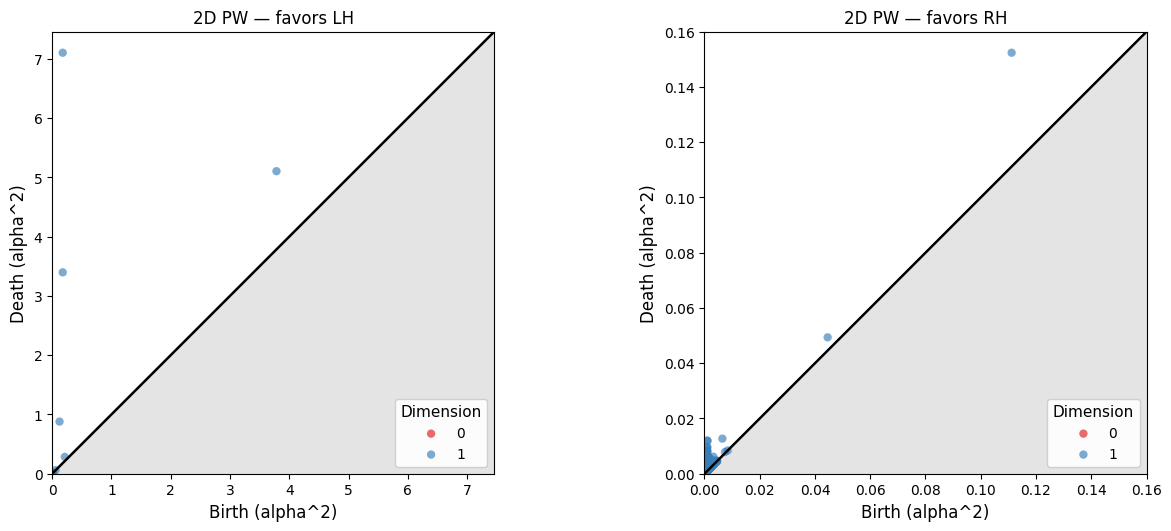

In [33]:
ph2w = ChiralPH2D_PW(pts, max_alpha=None, drop_infinite=True)
bn, w1 = ph2w.distances_weighted(gamma=0.35, q=1.0)
print("PW bottleneck:", bn)
print("PW W1:", w1)

LHpd, RHpd = ph2w.chiral_persistence_weighted(gamma=0.35, drop_inf=True)
fig, axs = plt.subplots(1, 2, figsize=(13, 5.2), constrained_layout=True)
ph2w._plot_pd_style(axs[0], LHpd, dims=(0,1), units_label=" (alpha^2)"); axs[0].set_title("2D PW — favors LH")
ph2w._plot_pd_style(axs[1], RHpd, dims=(0,1), units_label=" (alpha^2)"); axs[1].set_title("2D PW — favors RH")
plt.show()


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
AlphaParity2D — label‑free parity test on 2D point clouds using Alpha complexes
==============================================================================

What this is:
  • A clean replacement for triangle hand‑labeling. No LH/RH assignment.
  • Tests parity by MIRRORING the entire point set and comparing persistence.
  • Provides PD construction, plotting, bottleneck/Wasserstein distances, and
    an axis‑agnostic parity score (choose best mirror among a set of axes).

Key idea:
  If a dataset is parity‑symmetric, its PH is (approximately) invariant under
  reflections. If it breaks parity, PDs change in a measurable way.

Dependencies: numpy, matplotlib, gudhi

Example (Python):
    from alpha_parity2d import AlphaParity2D
    ap = AlphaParity2D(points, max_alpha=0.4)
    score = ap.parity_test(axes=("y","x","diag"))
    print(score)
    ap.plot_compare_with_mirror(axis=score["best_axis"])  # visual check

Author: Homology project rewrite (label‑free parity)
"""
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional, Iterable, Sequence

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import gudhi as gd
import gudhi.wasserstein as ws

# ---------------------------------------------------------------------------
# Core class: build Alpha complex PDs and do mirror-based parity tests
# ---------------------------------------------------------------------------

@dataclass
class AP2DConfig:
    max_alpha: Optional[float] = None   # cutoff in ALPHA units (Gudhi stores alpha^2)
    drop_infinite: bool = True          # drop features with infinite death by default


class AlphaParity2D:
    """Label‑free parity tester based on Alpha complexes in 2D.

    No LH/RH triangle classification. We compute PDs for the original point set,
    mirror the whole set across a chosen axis, compute PDs again, and compare.
    """

    def __init__(self, points: np.ndarray, config: Optional[AP2DConfig] = None):
        P = np.asarray(points)
        assert P.ndim == 2 and P.shape[1] >= 2, "points must be (N,>=2)"
        self.XY = P[:, :2].astype(float, copy=True)
        self.cfg = config or AP2DConfig()

    # ---- Alpha complex & persistence --------------------------------------
    def _alpha_tree(self, XY: Optional[np.ndarray] = None) -> gd.SimplexTree:
        pts = self.XY if XY is None else np.asarray(XY, float)
        ac = gd.AlphaComplex(points=pts)
        kwargs = {}
        if self.cfg.max_alpha is not None:
            kwargs["max_alpha_square"] = float(self.cfg.max_alpha) ** 2
        return ac.create_simplex_tree(**kwargs)

    @staticmethod
    def _pd_from_tree(st: gd.SimplexTree, drop_inf: bool = True):
        pd = st.persistence()
        if drop_inf:
            return [(d, (b, de)) for d, (b, de) in pd if np.isfinite(de)]
        return pd

    def persistence(self, XY: Optional[np.ndarray] = None, drop_inf: Optional[bool] = None):
        if drop_inf is None:
            drop_inf = self.cfg.drop_infinite
        st = self._alpha_tree(XY)
        return self._pd_from_tree(st, drop_inf)

    # ---- Utilities ---------------------------------------------------------
    @staticmethod
    def _pairs(pd, k: int):
        return [bd for dim, bd in pd if dim == k]

    @staticmethod
    def _as_arr(pairs):
        arr = np.array(pairs, float)
        return arr if arr.size else np.empty((0, 2))

    # ---- Mirroring ---------------------------------------------------------
    @staticmethod
    def mirror_points(points: np.ndarray, axis: str = "y"):
        XY = np.asarray(points)[:, :2].copy()
        if axis == "y":
            XY[:, 1] *= -1.0         # (x, y) -> (x, -y)
        elif axis == "x":
            XY[:, 0] *= -1.0         # (x, y) -> (-x, y)
        elif axis == "diag":
            XY = XY[:, ::-1]         # (x, y) -> (y, x)
        else:
            raise ValueError("axis must be 'x','y','diag'")
        return XY

    # ---- Parity distances --------------------------------------------------
    def distances_vs_mirror(self, axis: str = "y", q: float = 1.0,
                            drop_inf: Optional[bool] = None):
        """Compute PD(original) vs PD(mirrored along `axis`), return distances per k."""
        if drop_inf is None:
            drop_inf = self.cfg.drop_infinite
        PD  = self.persistence(drop_inf=drop_inf)
        PDm = self.persistence(self.mirror_points(self.XY, axis=axis), drop_inf=drop_inf)
        out = {}
        for k in (0, 1):
            A, B = self._pairs(PD, k), self._pairs(PDm, k)
            bn = gd.bottleneck_distance(A, B)
            wq = ws.wasserstein_distance(self._as_arr(A), self._as_arr(B), order=q)
            out[k] = {"bottleneck": float(bn), f"W{q}": float(wq)}
        return {"axis": axis, "distances": out, "PD": PD, "PD_mirror": PDm}

    def parity_test(self, axes: Sequence[str] = ("y", "x", "diag"), q: float = 1.0,
                    drop_inf: Optional[bool] = None, score_dim: int = 1,
                    score_metric: str = "bottleneck"):
        """Run multiple mirror axes and pick the one with *smallest* distance.

        Returns a dict with per-axis distances and the best axis (i.e., the
        reflection that makes the data look most similar to itself). For a
        parity‑symmetric cloud you expect *all* distances to be small.
        """
        if drop_inf is None:
            drop_inf = self.cfg.drop_infinite
        results = []
        for ax in axes:
            res = self.distances_vs_mirror(axis=ax, q=q, drop_inf=drop_inf)
            results.append(res)
        # choose best by the requested score
        def score(res):
            return res["distances"][score_dim][score_metric]
        best = min(results, key=score)
        return {"best_axis": best["axis"], "all": results,
                "score_dim": score_dim, "score_metric": score_metric}

    # ---- Plotting ----------------------------------------------------------
    @staticmethod
    def _plot_pd(ax, pd, dims=(0, 1), colors={0: "#e41a1c", 1: "#377eb8"}, s=28,
                 units_label: str = ""):
        # collect finite points
        finite = []
        for d in dims:
            A = np.array([bd for dim, bd in pd if dim == d], float)
            if A.size:
                finite.append(A[np.isfinite(A).all(axis=1)])
        if finite:
            S = np.vstack([a for a in finite if a.size])
            lo, hi = float(S.min()), float(S.max())
            pad = 0.05 * (hi - lo + 1e-12)
            xlim = (max(0.0, lo - pad), hi + pad)
            ylim = (max(0.0, lo - pad), hi + pad)
        else:
            xlim = ylim = (0.0, 1.0)
        # diagonal + shade
        ax.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="black", lw=1.8)
        tri = Polygon([[xlim[0], ylim[0]], [xlim[1], ylim[0]], [xlim[1], ylim[1]]],
                      closed=True, facecolor="#d3d3d3", edgecolor="none", alpha=0.6)
        ax.add_patch(tri)
        # scatter
        handles, labels = [], []
        for d in dims:
            A = np.array([bd for dim, bd in pd if dim == d], float)
            if A.size:
                m = np.isfinite(A[:, 1])
                sc = ax.scatter(A[m, 0], A[m, 1], s=s, color=colors.get(d, "C0"),
                                alpha=0.7, edgecolors="none", label=str(d))
                handles.append(sc); labels.append(str(d))
                if np.any(~m):
                    ax.scatter(A[~m, 0], np.full(np.sum(~m), ylim[1]), marker="v",
                               s=int(0.8*s), color=colors.get(d, "C0"), alpha=0.7)
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel(f"Birth {units_label}")
        ax.set_ylabel(f"Death {units_label}")
        leg = ax.legend(handles, [f"{lab}" for lab in labels], title="Dim",
                        loc="lower right", framealpha=0.9)
        if leg: leg.get_title().set_fontsize(10)

    @staticmethod
    def _shared_limits(*pds):
        pts = []
        for pd in pds:
            A = np.array([bd for _, bd in pd], float)
            if A.size:
                B = A[np.isfinite(A).all(axis=1)]
                if B.size:
                    pts.append(B)
        if not pts:
            return (0.0, 1.0)
        S = np.vstack(pts)
        lo, hi = float(S.min()), float(S.max())
        pad = 0.05 * (hi - lo + 1e-12)
        return (max(0.0, lo - pad), hi + pad)

    def plot_pd(self, pd=None, dims=(0, 1), units="alpha^2"):
        if pd is None:
            pd = self.persistence()
        fig, ax = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
        self._plot_pd(ax, pd, dims=dims, units_label=f"({units})")
        ax.set_title("Persistence diagram")
        plt.show()

    def plot_compare_with_mirror(self, axis: str = "y", dims=(0, 1), units="alpha^2"):
        PD  = self.persistence()
        PDm = self.persistence(self.mirror_points(self.XY, axis=axis))
        lim = self._shared_limits(PD, PDm)
        fig, axs = plt.subplots(1, 2, figsize=(13, 5.2), constrained_layout=True)
        self._plot_pd(axs[0], PD,  dims=dims, units_label=f"({units})"); axs[0].set_title("Original")
        self._plot_pd(axs[1], PDm, dims=dims, units_label=f"({units})"); axs[1].set_title(f"Mirrored: axis={axis}")
        for ax in axs:
            ax.set_xlim(lim); ax.set_ylim(lim)
        plt.show()

